In [54]:
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

# Let's try reading the CSV file using a semicolon as the delimiter
got_df = pd.read_csv("Game_of_Thrones_Script.csv", delimiter=';')

# Display the first few rows of the dataframe to understand its structure
got_df.head()

Release Date    Season    Episode     Episode Title          Name  \
0   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
1   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
2   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
3   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
4   2011-04-17  Season 1  Episode 1  Winter is Coming         gared   

                                            Sentence  
0  What do you expect? They're savages. One lot s...  
1  I've never seen wildlings do a thing like this...  
2                             How close did you get?  
3                            Close as any man would.  
4                   We should head back to the wall.

In [55]:
# Getting the unique names
unique_characters = got_df['Name'].unique()

# Providing the complete list of unique characters
unique_characters_list = list(unique_characters)

# Displaying the total number of unique characters
total_characters = len(unique_characters_list)
total_characters, unique_characters_list

(520,
 ['waymar royce',
  'will',
  'gared',
  'jon snow',
  'septa mordane',
  'sansa stark',
  'eddard stark',
  'robb stark',
  'jonrobb',
  'rodrik cassel',
  'catelyn stark',
  'bran stark',
  'theon greyjoy',
  'jaime lannister',
  'cersei lannister',
  'maester luwin',
  'luwin',
  'arya stark',
  'robert baratheon',
  'tyrion lannister',
  'ros',
  'viserys targaryen',
  'daenerys targaryen',
  'maid',
  'illyrio',
  'benjen stark',
  'a voice',
  'jorah mormont',
  'drogo',
  'sandor clegane',
  'doreah',
  'irri',
  'joffrey lannister',
  'myrcella baratheon',
  'assassin',
  'jhiqui',
  'mycah',
  'soldier',
  'jory cassel',
  'kings landing guard',
  'varys',
  'renly baratheon',
  'petyr baelish',
  'grand maester pycelle',
  'old nan',
  'guard',
  'alliser thorne',
  'jeor mormont',
  'grenn',
  'pyp',
  'rast',
  'barristan selmy',
  'lancel lannister',
  'rakharo',
  'yoren',
  'maester aemon',
  'syrio forel',
  'sam',
  'janos slynt',
  'hugh of vale',
  'tobho mott'

In [56]:
# Load the dataset
got_df = pd.read_csv('Game_of_Thrones_Script.csv', delimiter=';')

# Function to process a batch of lines
def process_batch(batch):
    character_counts = Counter(batch['Name'])
    interactions = [(char1, char2) for char1 in character_counts for char2 in character_counts if char1 != char2 and character_counts[char1] > 1 and character_counts[char2] > 1]
    return interactions

# Function to process each episode
def process_episode(episode_df):
    interactions = []
    for start in range(0, len(episode_df), 10):
        batch = episode_df.iloc[start:start + 10]
        batch_interactions = process_batch(batch)
        interactions.extend(batch_interactions)
    return interactions

# Analyze each season and episode
seasons = got_df['Season'].unique()
season_graphs = {}

for season in seasons:
    season_df = got_df[got_df['Season'] == season]
    episodes = season_df['Episode'].unique()
    season_interactions = Counter()

    for episode in episodes:
        episode_df = season_df[season_df['Episode'] == episode]
        interactions = process_episode(episode_df)
        season_interactions.update(interactions)

    # Create a graph for the season
    G = nx.Graph()
    for (char1, char2), count in season_interactions.items():
        G.add_edge(char1, char2, weight=count)
    
    season_graphs[season] = G


In [57]:
def process_episode_with_rolling_window_unique(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        # Update interactions count for each unique pair of interacting characters
        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Processing each episode in each season with the revised approach
season_interactions_unique = {}
for season in got_df['Season'].unique():
    season_df = got_df[got_df['Season'] == season]
    season_interactions_unique[season] = Counter()

    for episode in season_df['Episode'].unique():
        episode_df = season_df[season_df['Episode'] == episode]
        episode_interactions = process_episode_with_rolling_window_unique(episode_df)
        season_interactions_unique[season].update(episode_interactions)

# Example: Displaying the top 10 interactions for a specific season (e.g., Season 1)
top_10_interactions_season_1_unique = season_interactions_unique['Season 1'].most_common(10)
print(top_10_interactions_season_1_unique)

[(frozenset({'eddard stark', 'robert baratheon'}), 211), (frozenset({'daenerys targaryen', 'jorah mormont'}), 169), (frozenset({'eddard stark', 'petyr baelish'}), 165), (frozenset({'eddard stark', 'cersei lannister'}), 144), (frozenset({'eddard stark', 'arya stark'}), 141), (frozenset({'sam', 'jon snow'}), 138), (frozenset({'shae', 'tyrion lannister'}), 99), (frozenset({'robb stark', 'catelyn stark'}), 97), (frozenset({'cersei lannister', 'robert baratheon'}), 94), (frozenset({'bronn', 'tyrion lannister'}), 88)]


In [59]:
## Filtering out too-general characters from the interactions
# Re-defining the list of non-specific character names to remove
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace"
]

# Re-defining the function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        # Ensure both characters in the pair are not in the non-specific list
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Apply the filter to each season's interactions
filtered_season_interactions = {}
for season in season_interactions_unique:
    filtered_season_interactions[season] = filter_interactions(season_interactions_unique[season])

# Example: Displaying the top 10 interactions for a specific season (e.g., Season 1) after filtering
filtered_top_10_season_1 = filtered_season_interactions['Season 1'].most_common(10)
filtered_top_10_season_1

[(frozenset({'eddard stark', 'robert baratheon'}), 211),
 (frozenset({'daenerys targaryen', 'jorah mormont'}), 169),
 (frozenset({'eddard stark', 'petyr baelish'}), 165),
 (frozenset({'cersei lannister', 'eddard stark'}), 144),
 (frozenset({'arya stark', 'eddard stark'}), 141),
 (frozenset({'jon snow', 'sam'}), 138),
 (frozenset({'shae', 'tyrion lannister'}), 99),
 (frozenset({'catelyn stark', 'robb stark'}), 97),
 (frozenset({'cersei lannister', 'robert baratheon'}), 94),
 (frozenset({'bronn', 'tyrion lannister'}), 88)]

In [49]:
# Saving all interactions per season into an xlsx file
def create_interaction_dataframe_filtered(interactions):
    # Converting interaction data to a format suitable for DataFrame
    data = [{'Characters': '-'.join(str(char) for char in pair), 'Interactions': count}
            for pair, count in interactions.items()]
    df = pd.DataFrame(data)

    # Sorting by interaction count in descending order
    df = df.sort_values(by='Interactions', ascending=False)
    return df

# Creating DataFrames for each season with filtered interactions and saving to an Excel file with multiple sheets
with pd.ExcelWriter('Game_of_Thrones_Filtered_Interactions.xlsx') as writer:
    for season in filtered_season_interactions:
        df = create_interaction_dataframe_filtered(filtered_season_interactions[season])
        df.to_excel(writer, sheet_name=season, index=False)

# The Excel file 'Game_of_Thrones_Filtered_Interactions.xlsx' is in the current directory, no need to run this code anymore

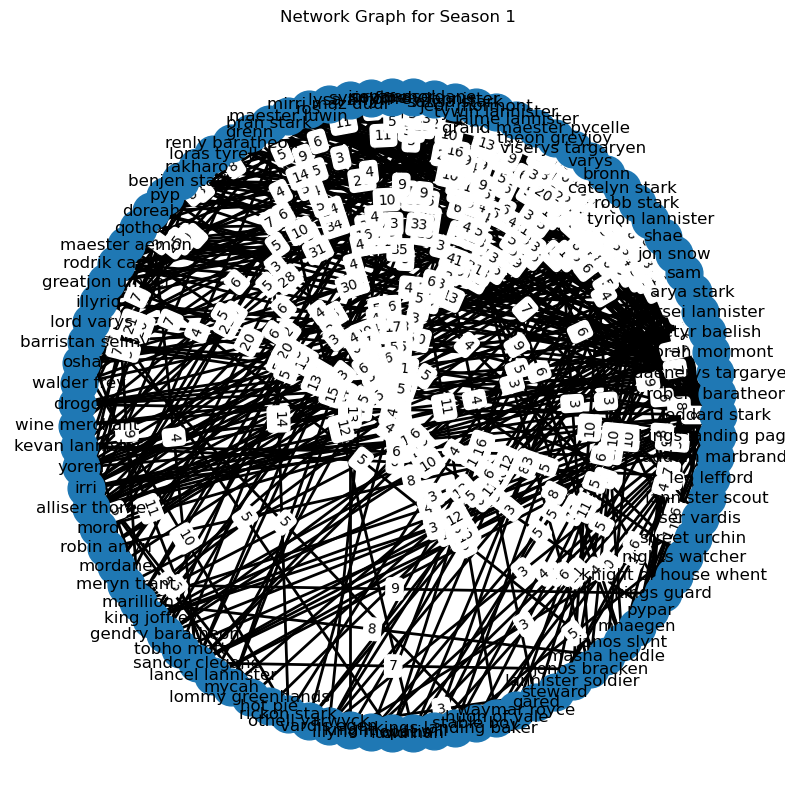

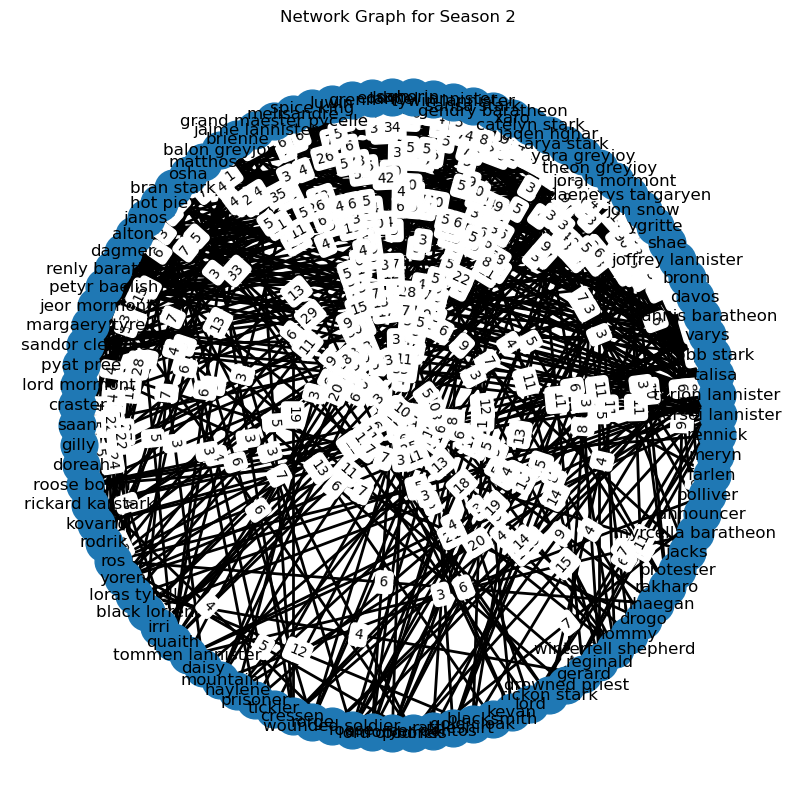

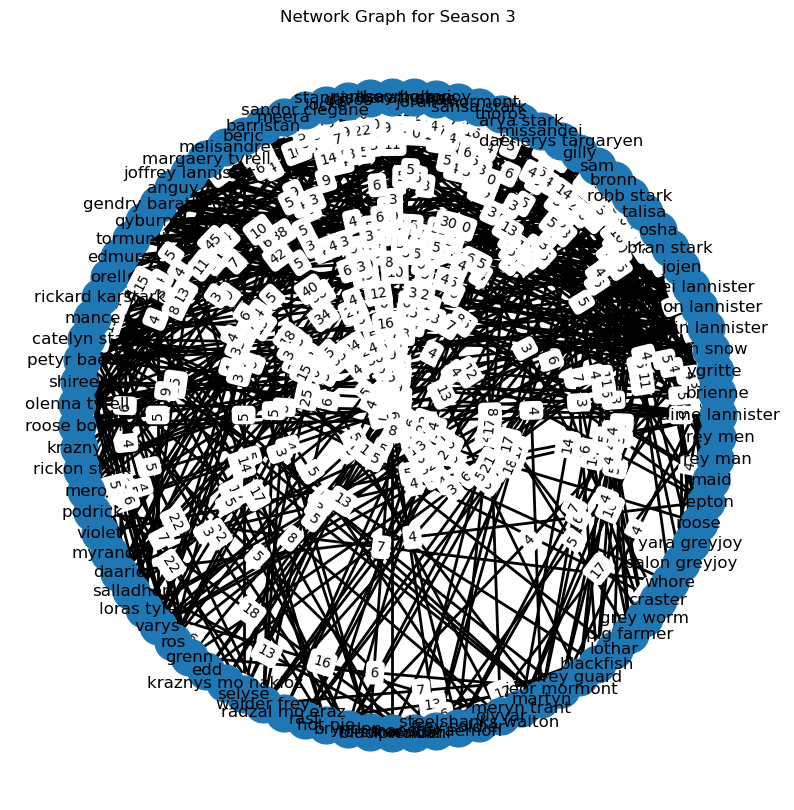

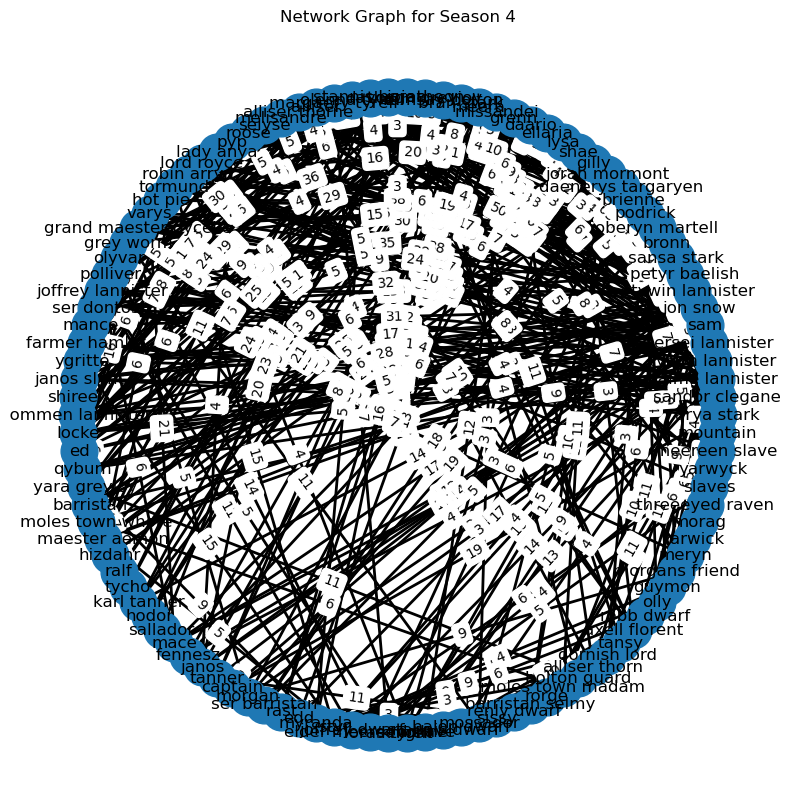

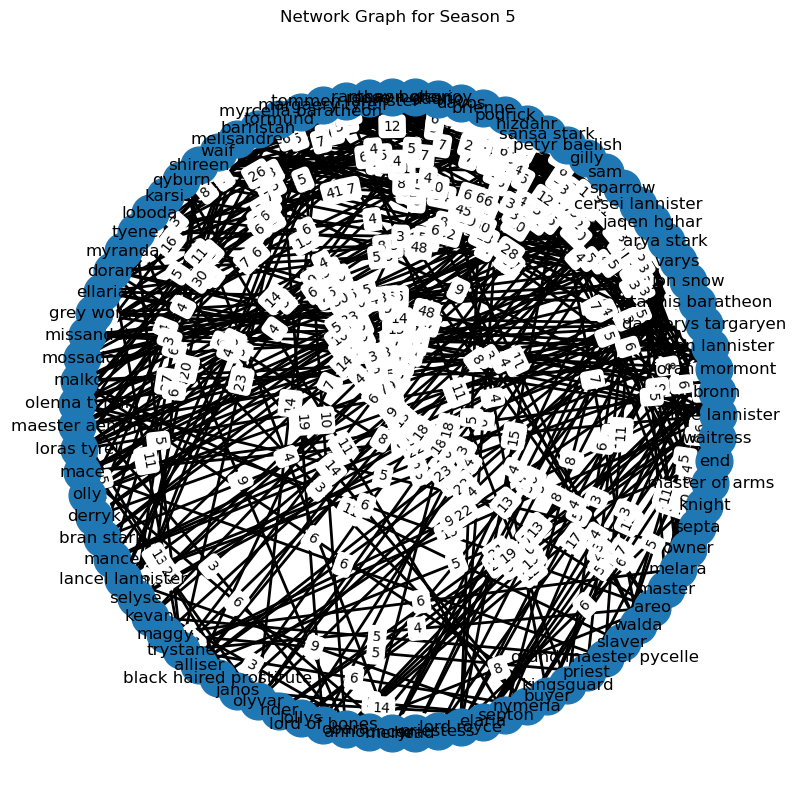

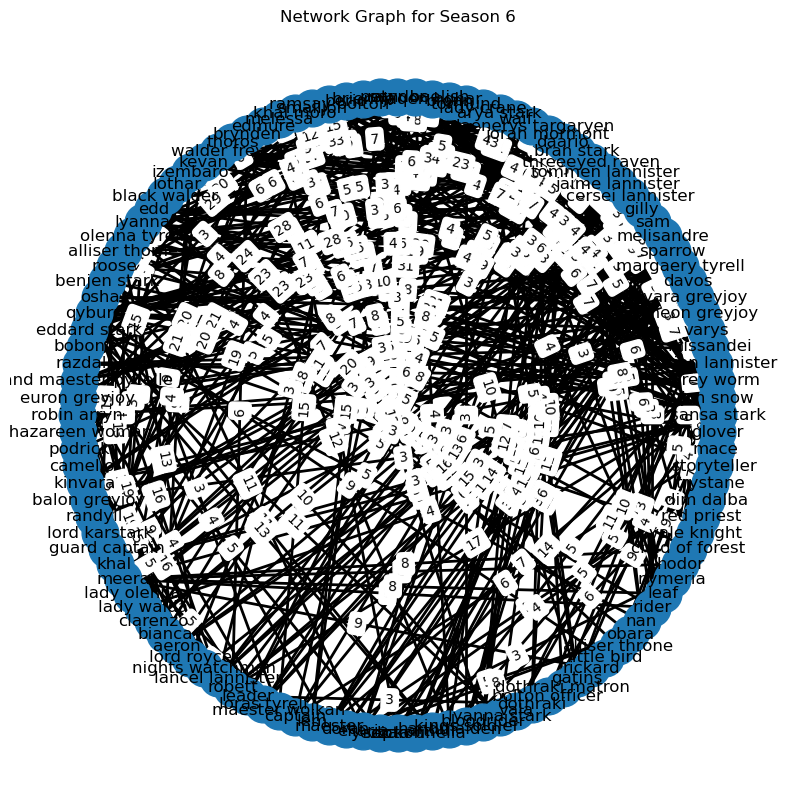

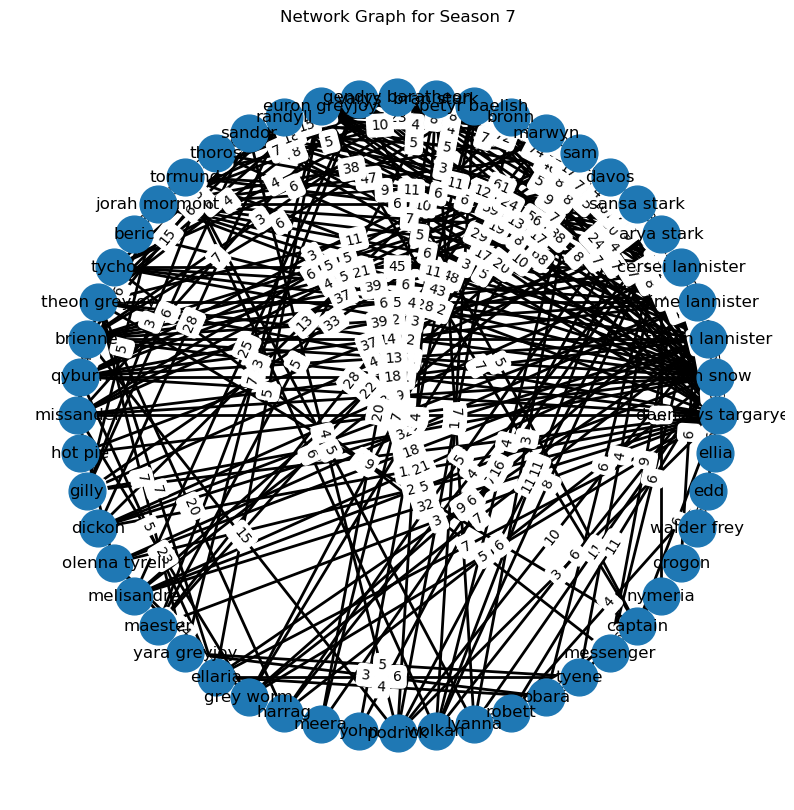

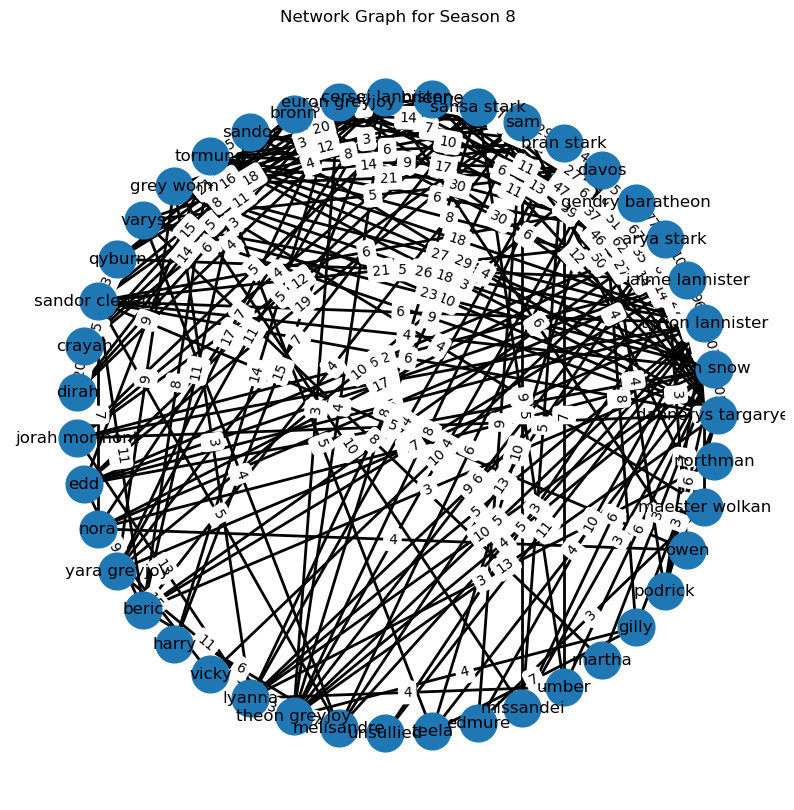

In [61]:
# Load the Excel file with interactions
excel_file = 'Game_of_Thrones_Filtered_Interactions.xlsx'
seasons_data = pd.read_excel(excel_file, sheet_name=None)  # Loads all sheets into a dictionary

# Function to build and visualize a network for a given season
def build_and_visualize_network(season_df, season_name):
    G = nx.Graph()

    # Adding edges and edge weights (interactions)
    for _, row in season_df.iterrows():
        characters = row['Characters'].split('-')
        interaction_count = row['Interactions']
        if interaction_count >= 3: # Only add ineractions with 3 or more interactions
            G.add_edge(characters[0], characters[1], weight=interaction_count)

    # Adding node attributes (total interactions)
    for node in G.nodes():
        total_interactions = sum([G[node][n]['weight'] for n in G.neighbors(node)])
        G.nodes[node]['total_interactions'] = total_interactions

    # Visualizing the network
    plt.figure(figsize=(10, 10))
    pos = nx.circular_layout(G)  # Circle layout
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

    plt.title(f"Network Graph for {season_name}")
    plt.axis("off")
    plt.show()

    return G

# Building and visualizing networks for each season
networks = {}
for season in seasons_data:
    networks[season] = build_and_visualize_network(seasons_data[season], season)



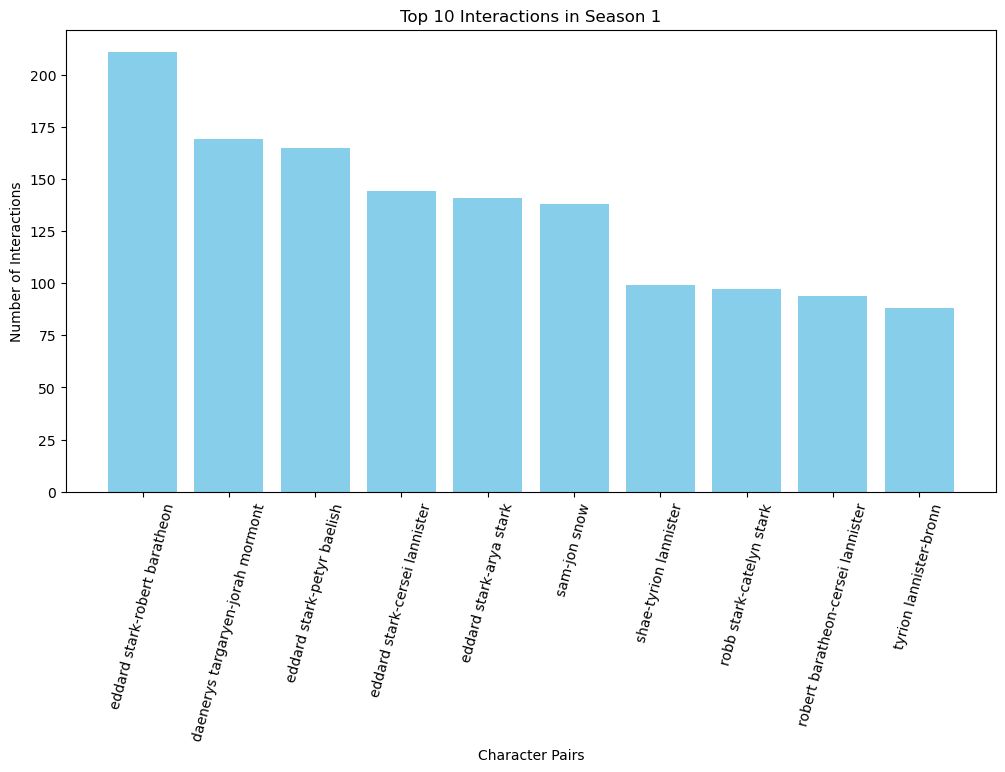

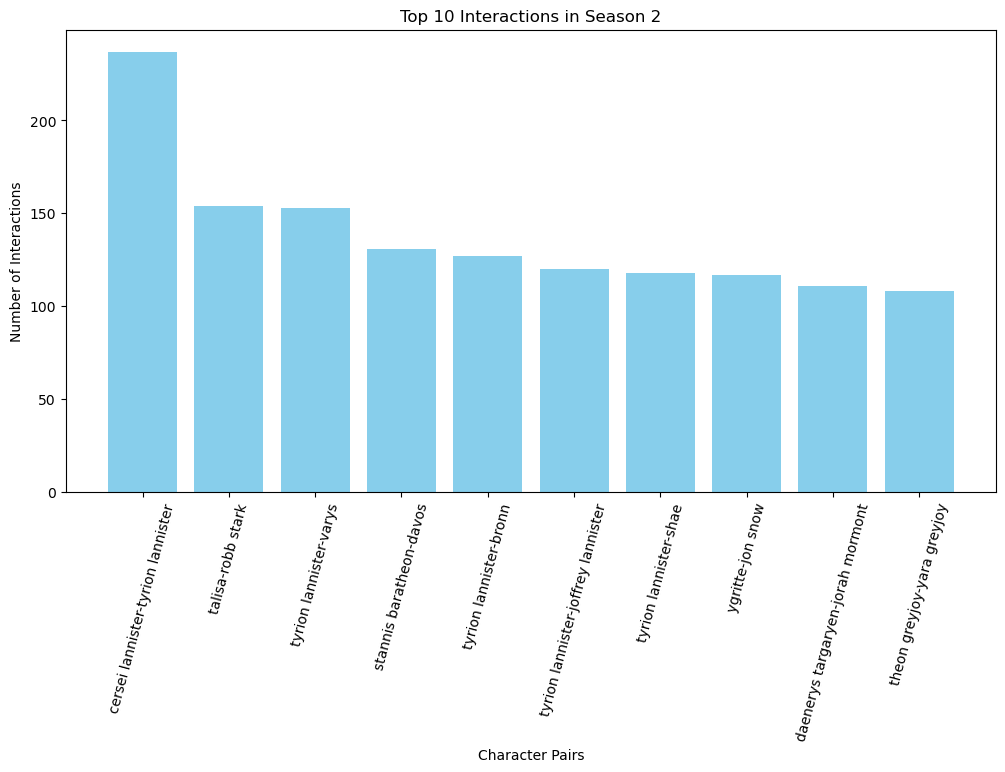

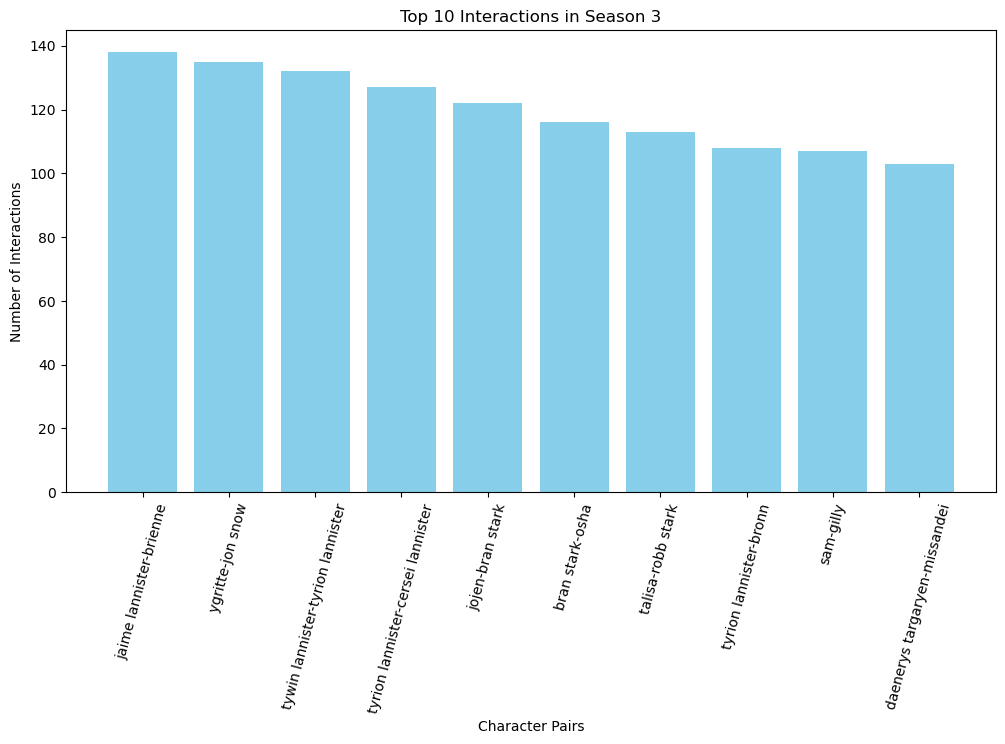

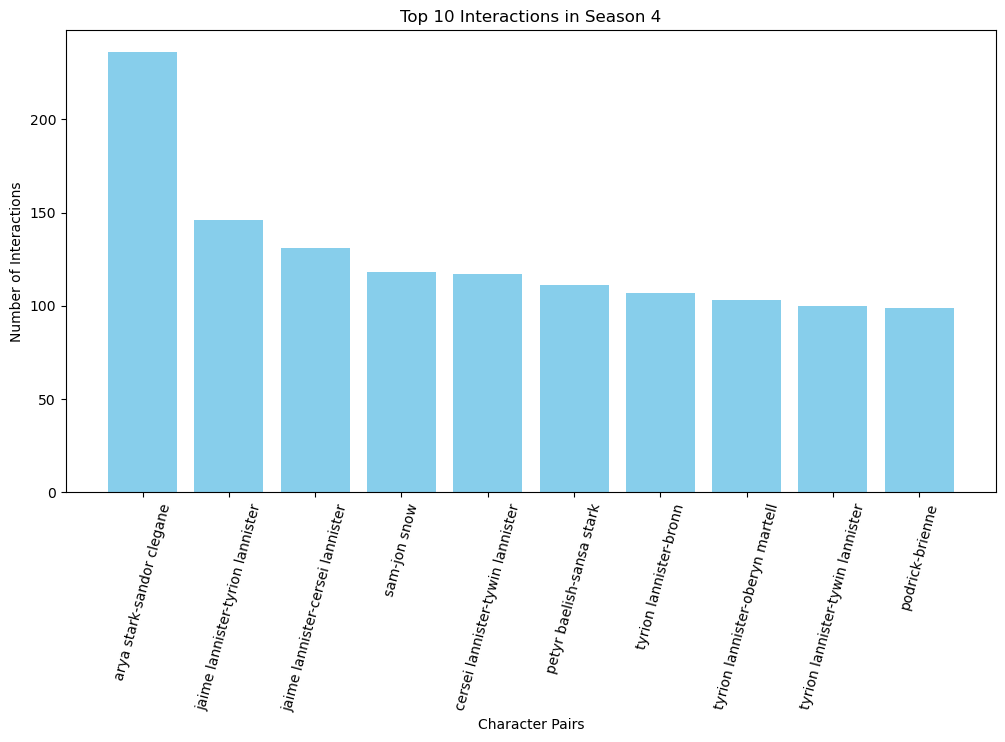

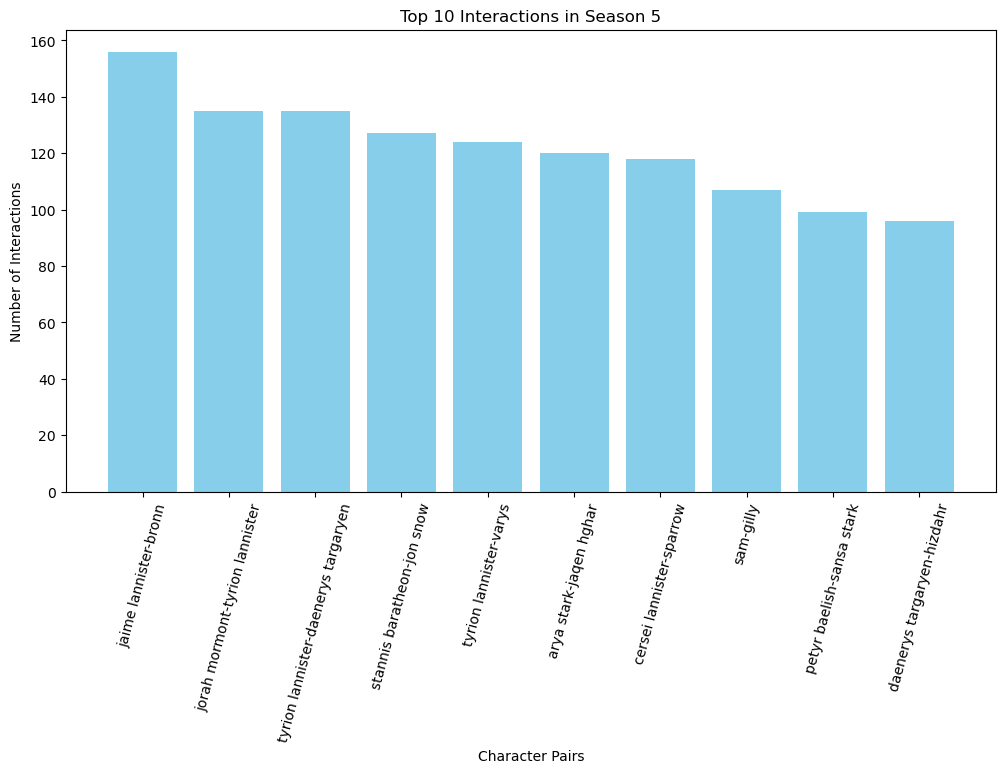

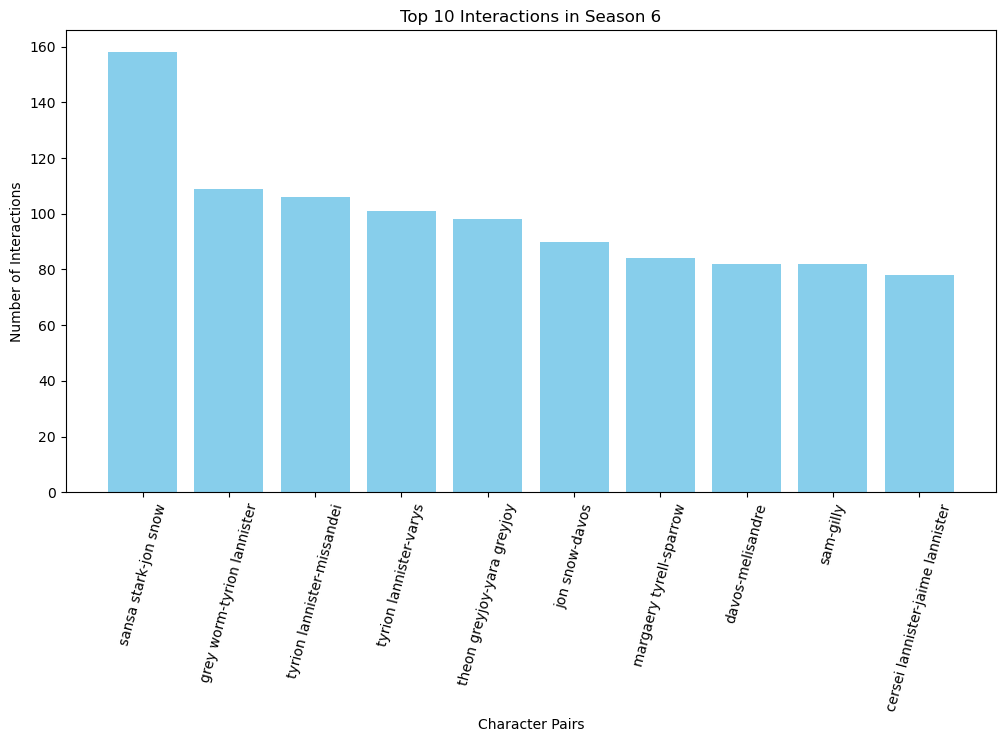

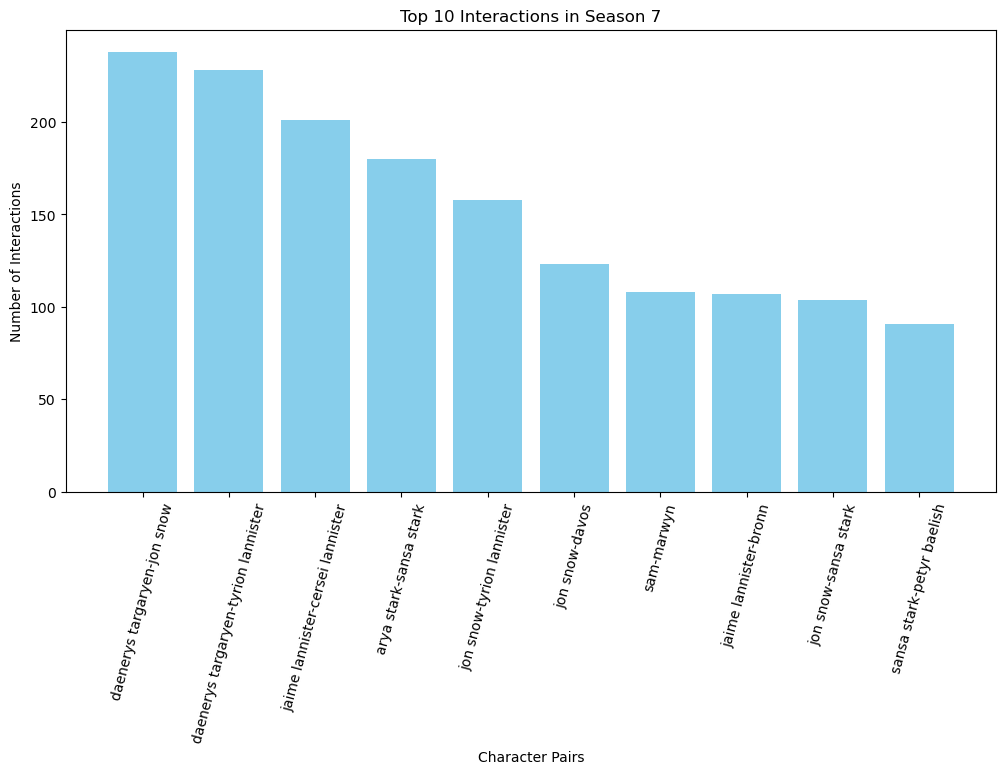

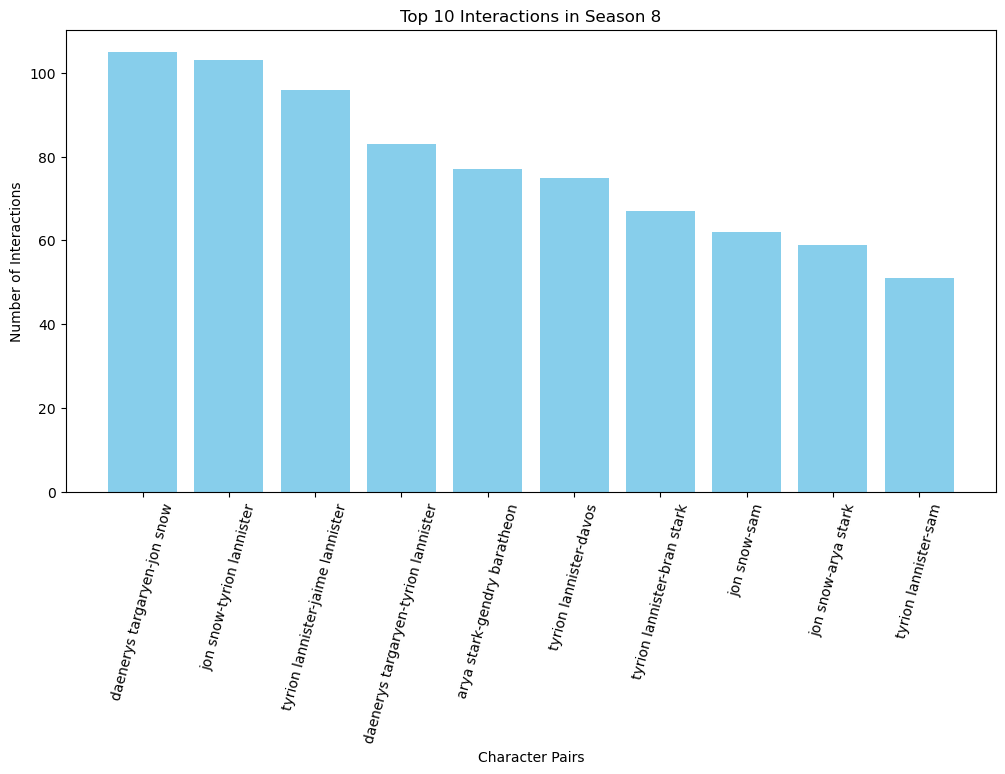

In [62]:
# Function to plot top 10 interactions for each season in a barplot
def plot_top_interactions_filtered(network, season_name, top_n=10):
    # Extract interactions and their weights (number of interactions)
    interactions = [(u, v, d['weight']) for u, v, d in network.edges(data=True)]
    interactions.sort(key=lambda x: x[2], reverse=True)  # Sort by number of interactions

    # Select top interactions
    top_interactions = interactions[:top_n]

    # Prepare data for plotting
    labels = [f"{u}-{v}" for u, v, _ in top_interactions]
    values = [w for _, _, w in top_interactions]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Character Pairs')
    plt.ylabel('Number of Interactions')
    plt.title(f'Top {top_n} Interactions in {season_name}')
    plt.xticks(rotation=75)  # Adjust rotation here
    plt.show()

# Plotting top 10 interactions for each of the seasons
for season in networks:
    plot_top_interactions_filtered(networks[season], season)


In [69]:
# Print the top 3 most central characters for each season, output is truncated so use a text editor to see the results
for season in networks:
    print(season, "top 3 most central characters")
    sorted_characters = sorted(networks[season].nodes(data=True), key=lambda x: x[1]['total_interactions'], reverse=True)
    for character, data in sorted_characters[:3]:
        print(f"{character}: {data['total_interactions']}")
    print()

Season 1 top 3 most central characters
eddard stark: 1646
tyrion lannister: 1079
jon snow: 855

Season 2 top 3 most central characters
tyrion lannister: 1392
cersei lannister: 685
theon greyjoy: 666

Season 3 top 3 most central characters
tyrion lannister: 915
arya stark: 579
bran stark: 523

Season 4 top 3 most central characters
tyrion lannister: 905
jaime lannister: 689
jon snow: 663

Season 5 top 3 most central characters
cersei lannister: 734
tyrion lannister: 728
jon snow: 717

Season 6 top 3 most central characters
tyrion lannister: 638
jon snow: 561
jaime lannister: 542

Season 7 top 3 most central characters
jon snow: 1101
tyrion lannister: 933
daenerys targaryen: 876

Season 8 top 3 most central characters
tyrion lannister: 776
jon snow: 572
daenerys targaryen: 437



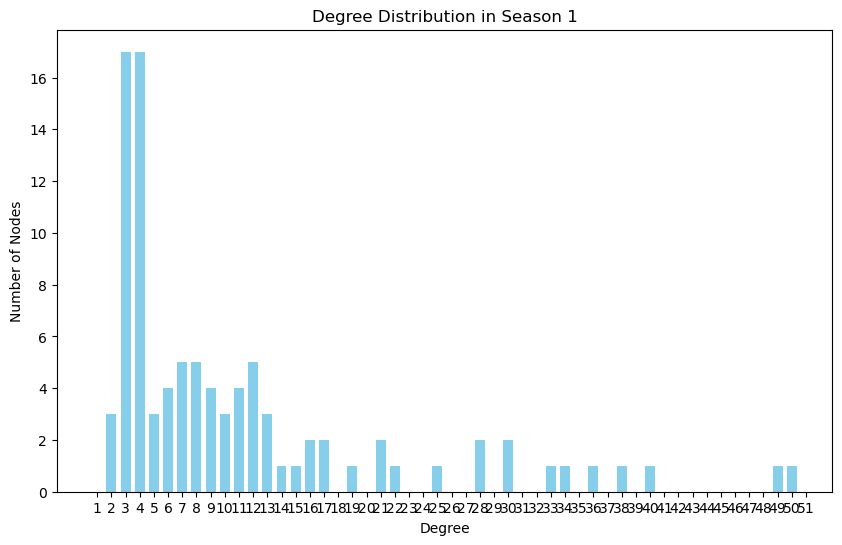

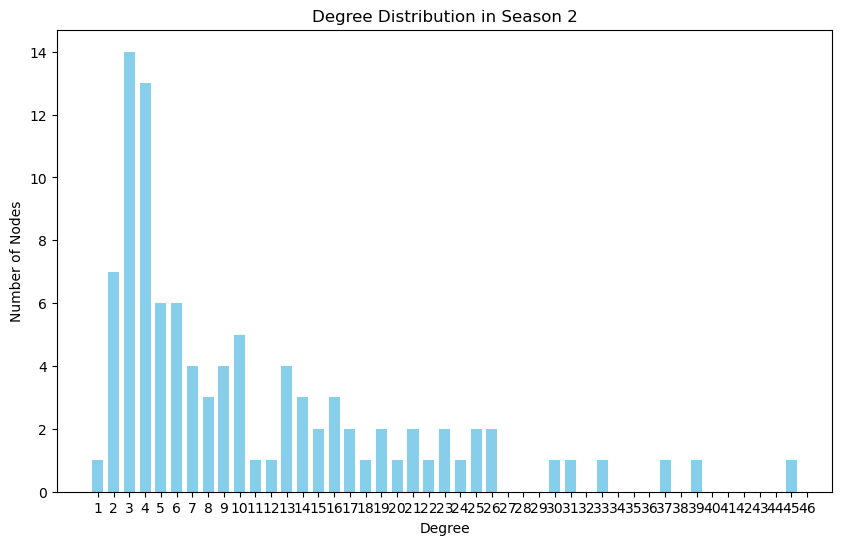

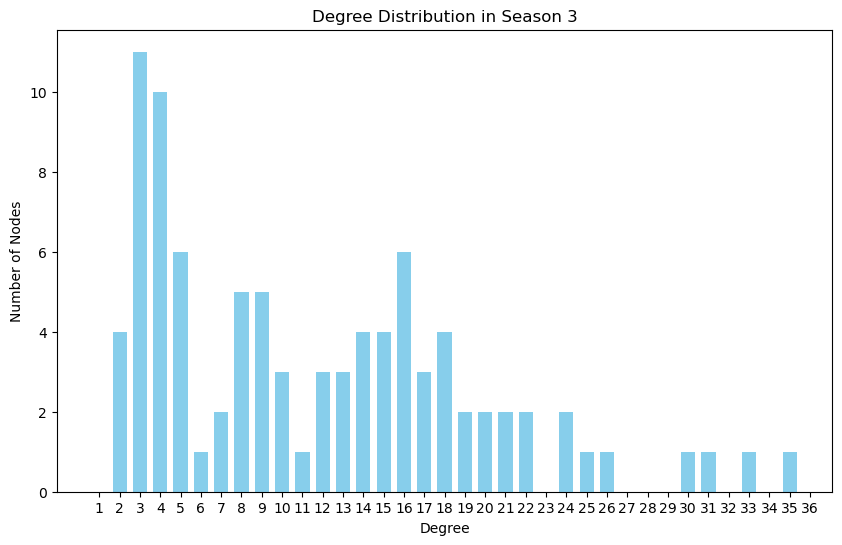

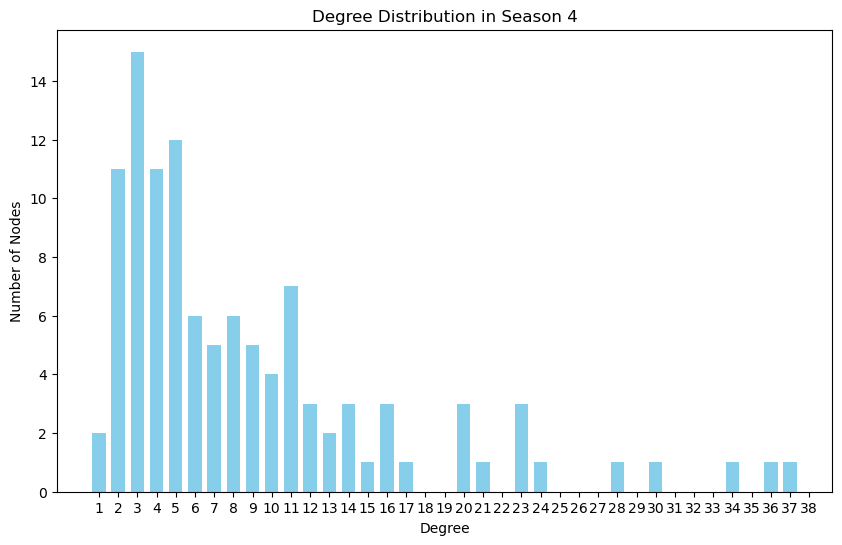

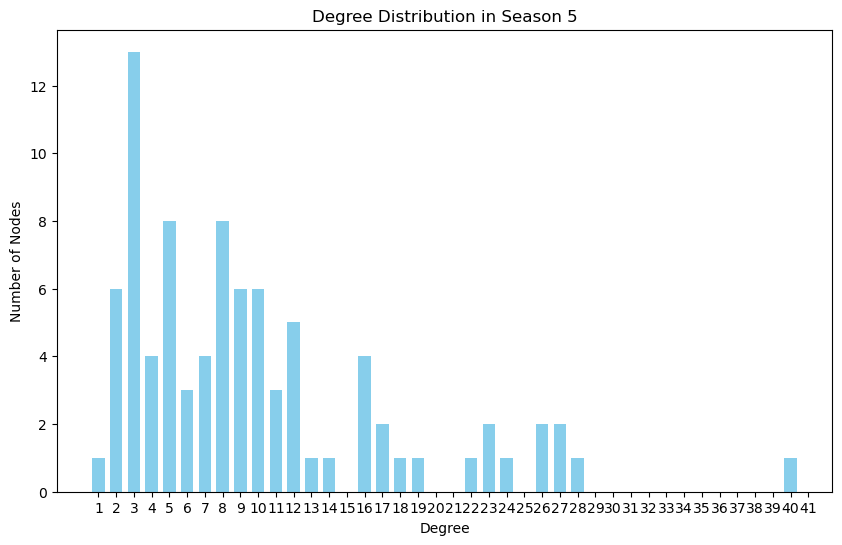

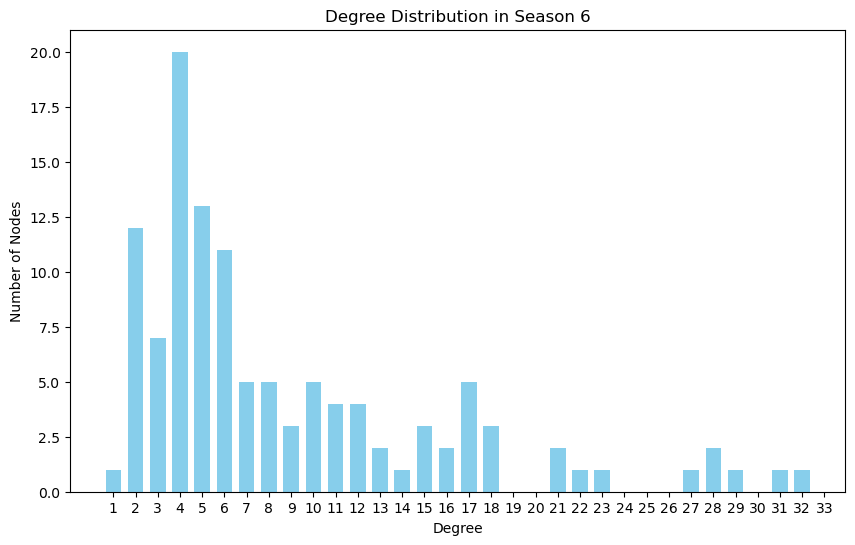

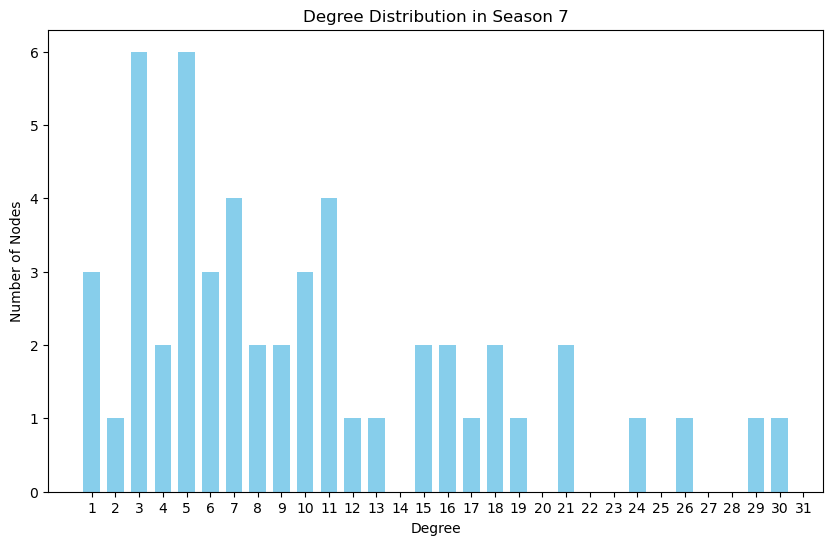

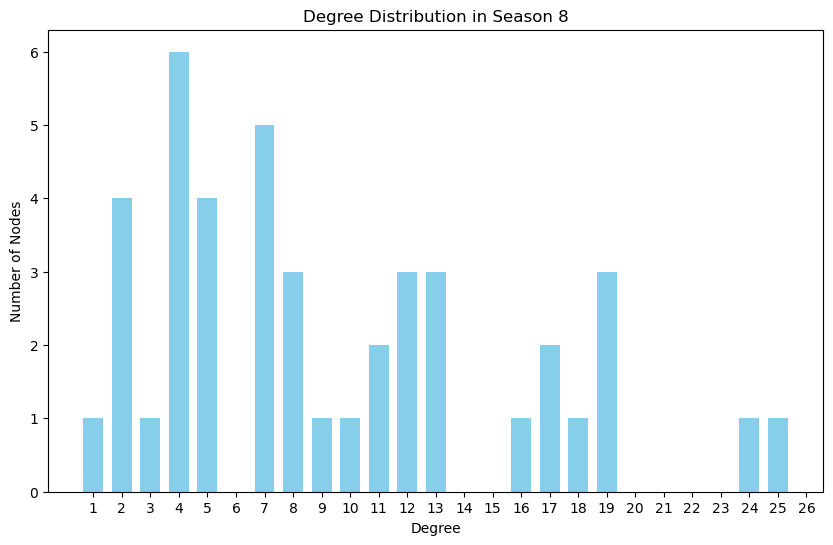

In [70]:
# Function to plot the degree distribution for each season
def plot_degree_distribution(network, season_name):
    degrees = [degree for _, degree in network.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=range(1, max(degrees)+1), align='left', rwidth=0.7, color='skyblue')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title(f'Degree Distribution in {season_name}')
    plt.xticks(range(1, max(degrees)+1))
    plt.show()

# Plotting degree distributions for each season
for season in networks:
    plot_degree_distribution(networks[season], season)


In [71]:
# Function to print the number of nodes, number of links, and top 5 most connected nodes for each season
def print_network_statistics(network, season_name):
    num_nodes = network.number_of_nodes()
    num_links = network.number_of_edges()
    
    # Calculating the degree for each node and sorting them
    degrees = dict(network.degree())
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

    # Top 5 most connected nodes
    top_5_nodes = sorted_degrees[:5]

    print(f"Season: {season_name}")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Links: {num_links}")
    print("Top 5 Most Connected Nodes:")
    for node, degree in top_5_nodes:
        print(f"  {node}: {degree} connections")
    print("\n")

# Printing statistics for each season
for season in networks:
    print_network_statistics(networks[season], season)


Season: Season 1
Number of Nodes: 95
Number of Links: 524
Top 5 Most Connected Nodes:
  eddard stark: 51 connections
  tyrion lannister: 49 connections
  jon snow: 40 connections
  catelyn stark: 38 connections
  daenerys targaryen: 36 connections


Season: Season 2
Number of Nodes: 99
Number of Links: 535
Top 5 Most Connected Nodes:
  tyrion lannister: 46 connections
  daenerys targaryen: 39 connections
  theon greyjoy: 37 connections
  arya stark: 33 connections
  jon snow: 31 connections


Season: Season 3
Number of Nodes: 91
Number of Links: 530
Top 5 Most Connected Nodes:
  tyrion lannister: 36 connections
  robb stark: 33 connections
  bran stark: 31 connections
  arya stark: 30 connections
  talisa: 26 connections


Season: Season 4
Number of Nodes: 110
Number of Links: 489
Top 5 Most Connected Nodes:
  tyrion lannister: 38 connections
  jon snow: 36 connections
  daenerys targaryen: 34 connections
  jaime lannister: 30 connections
  cersei lannister: 28 connections


Season: Se

In [78]:
# Fancy plot
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_cytoscape as cyto
from dash.dependencies import Input, Output
import networkx as nx

# Convert networkx graph to cytoscape elements
def network_to_cytoscape(network):
    elements = []
    for u, v, data in network.edges(data=True):
        elements.append({'data': {'source': u, 'target': v, 'weight': data['weight']}})
    for node in network.nodes():
        elements.append({'data': {'id': node, 'label': node}})
    return elements

app = dash.Dash(__name__)

# Cytoscape stylesheet
stylesheet = [
    {
        'selector': 'node',
        'style': {
            'background-color': 'black',
            'label': 'data(label)',
            'color': 'red',
            'text-valign': 'center',
            'text-halign': 'center'
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'grey',
            'width': 2
        }
    }
]

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='season-dropdown',
        options=[{'label': season, 'value': season} for season in networks.keys()],
        value='Season 1'  # Default value
    ),
    cyto.Cytoscape(
        id='network-graph',
        layout={'name': 'circle'},
        style={'width': '100%', 'height': '400px', 'background-color': 'white'},
        stylesheet=stylesheet
    )
])

# Callback to update graph based on season selection
@app.callback(
    Output('network-graph', 'elements'),
    [Input('season-dropdown', 'value')]
)
def update_graph(selected_season):
    network = networks[selected_season]
    return network_to_cytoscape(network)

if __name__ == '__main__':
    app.run_server(debug=True)
